![image](../data/images/banner.png)


# **Taller 1**

- **Integrante 1: Javier Alejandro Gómez Muñoz
- **Integrante 2:**

### **Problemática**:
En un entorno clínico, los profesionales de la salud enfrentan el desafío de interpretar los resultados de las pruebas médicas de manera rápida y precisa para tomar decisiones informadas sobre el tratamiento y el seguimiento de los pacientes. Sin embargo, debido a la gran cantidad de datos y la complejidad de las condiciones médicas, esta tarea resulta muy tediosa.

Problema específico: Los resultados de las pruebas médicas, que se describen como "Normal," "Anormal," o "Inconcluso," deben ser interpretados con precisión para determinar la necesidad de seguimiento adicional o tratamiento especializado.
        
Los datos y el diccionario de datos lo pueden encontrar [acá](https://www.kaggle.com/datasets/prasad22/healthcare-dataset/data).

&nbsp;

### **Preguntas:**
1. Realice el debido preprocesamiento de los datos, feature engineering, EDA, Encoding Techniques, etc... Dentro de un pipeline que almacene todo el proceso.

2. Genere un modelo MLP base de predicción. Confirme si su modelo generaliza bien, o si presenta sobreajuste o subajuste. Si es alguna de las dos últimas opciones, ¿qué opciones propone para que la red MLP generalice mejor?

3. Realice una búsqueda de hiperparámetros para encontrar el mejor modelo. Documentarlo en un cuadro comparativon con el modelo base del punto anterior.

4. ¿Cómo podemos mejorar el tiempo de entrenamiento de los modelos? ¿Que es el EarlyStopping y cómo se puede automatizar utilizando callback? Está pregunta es más teórica, pero pueden incluir código si lo creen necesario.

### NOTA IMPORTANTE
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `taller_1_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

# Desarrollo

In [1]:
from pathlib import Path

import kaggle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from ydata_profiling import ProfileReport

pd.options.display.max_columns = 999

In [2]:
# Descargar el dataset
kaggle.api.dataset_download_files('prasad22/healthcare-dataset', path='../data/raw/data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/prasad22/healthcare-dataset


In [3]:
directory = Path("../data/raw/data")
file_name = next(directory.iterdir(), None)
str(file_name)

'../data/raw/data/healthcare_dataset.csv'

In [4]:
# Cargar en objeto pandas
df = pd.read_csv(str(file_name))
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Test Results"],
    random_state=123
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

Text(0.5, 1.0, 'Distribución de Resultados de Prueba en Conjunto de Entrenamiento y Prueba')

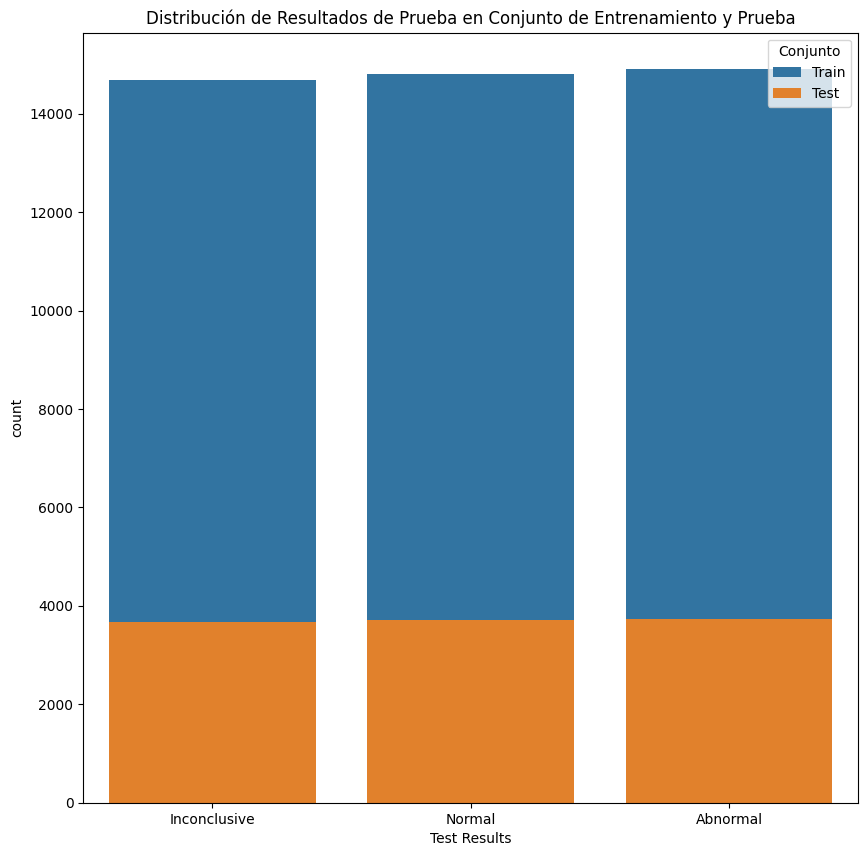

In [5]:
plt.figure(figsize=(10,10))
sns.countplot(df_train, x="Test Results", label='Train')
sns.countplot(df_test, x="Test Results", label='Test')
plt.legend(title='Conjunto')
plt.title("Distribución de Resultados de Prueba en Conjunto de Entrenamiento y Prueba")

In [6]:
ohe = OneHotEncoder(sparse_output=False)

onehot_data = ohe.fit_transform(df_train[['Test Results']])
encoded_df = pd.DataFrame(onehot_data, columns=ohe.get_feature_names_out(['Test Results']), index=df_train.index)
train_data = pd.concat([df_train, encoded_df], axis=1)


X_train = train_data.drop(columns=['Test Results', 'Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal'])
y_train = train_data[['Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal']]


display(X_train)
display(y_train)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication
30555,naTalIe perRY,50,Female,B+,Hypertension,2020-08-30,Bryan Hudson,and Watts Sons,Medicare,38547.349646,331,Urgent,2020-08-31,Lipitor
21005,TiNA WHIte,49,Male,AB-,Diabetes,2020-06-11,Katrina Perkins,Sanchez-Adams,UnitedHealthcare,38157.779638,461,Elective,2020-06-14,Aspirin
11483,aMber GrEenE,63,Male,B-,Hypertension,2021-03-03,Ryan Chang,Lozano Ltd,Aetna,27972.562933,378,Elective,2021-03-22,Paracetamol
8731,rACHEL hAlL,24,Male,B-,Hypertension,2023-10-03,Elizabeth Sheppard,Bridges-Phillips,Blue Cross,15188.141699,358,Elective,2023-10-17,Aspirin
33319,anThOnY BOyd,22,Female,B-,Diabetes,2023-06-04,Hannah Fox,"Wright, Ward and Williams",Aetna,9763.639991,399,Emergency,2023-06-19,Penicillin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33564,pAmELa poPE,65,Male,AB+,Asthma,2023-05-13,Tara Williams,Phillips-Fox,UnitedHealthcare,35310.977876,143,Urgent,2023-05-19,Lipitor
22701,RAChel HaWkiNS,21,Male,AB-,Diabetes,2022-07-23,Eric Hart,Daniel Inc,Cigna,3786.490452,222,Elective,2022-08-20,Ibuprofen
49772,CarMEN elLiOTt,27,Female,O-,Obesity,2022-08-19,Cassandra Mcgrath,Roth-Dawson,Blue Cross,15261.968232,269,Elective,2022-09-03,Penicillin
48989,mArk walKer,67,Female,AB-,Cancer,2023-09-09,Douglas Anderson,Robertson-Nicholson,Cigna,10710.984365,299,Elective,2023-09-16,Penicillin


,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
30555,0.0,1.0,0.0
21005,0.0,0.0,1.0
11483,0.0,0.0,1.0
8731,0.0,0.0,1.0
33319,1.0,0.0,0.0
...,...,...,...
33564,1.0,0.0,0.0
22701,0.0,0.0,1.0
49772,0.0,0.0,1.0
48989,0.0,0.0,1.0


## Entendimiento de los datos

| Columna | Descripción |
|---|---|
| Name | Representa el nombre del paciente asociado al registro | 
| Age | Representa la edad del paciente al ingreso, expresado en años |
| Gender | Genero del paciente, Masculino o Femenino |
| Blood Type | Tipo de sangre |
| Medical Condition | Condición médica primaria |
| Date of Admission | Fecha de la admision |
| Doctor | Nombre del doctor responsable de la admision |
| Hospital | Hospital donde fue admitido el paciente |
| Insurance Provider | Nombre del asegurador del paciente |
| Billing Amount| Cantidad de dinero facturada al paciente |
| Room Number | Numero de la habitacion |
| Admission Type | Tipo de admision: emergencia, electivo o urgente |
| Discharge Date | Fecha en la que el paciente fue dado de alta |
| Medication | Medicamento prescrito para el paciente |
| Test Results | Resultados de las pruebas realizadas en la admision: Normal, Anormal o inconcluso |

In [7]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


### Reporte

In [8]:
# profile = ProfileReport(df, title='Report', html={'style':{'full_width':True}})
# profile.to_file(output_file="healthcare.html")

### Valores Nulos

In [9]:
df.isnull().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

In [10]:
df_train.isnull().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

In [11]:
df_test.isnull().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

### Valores duplicados

In [12]:
df.duplicated().sum()

534

In [13]:
df_train.duplicated().sum()

342

In [14]:
df_test.duplicated().sum()

18

### Dtypes

In [15]:
columns_to_drop = []
columns_to_cast = []
for col in df.select_dtypes(include=['object']).columns:
    print(f"Frecuencia de valores en '{col}':")
    value_counts = df[col].value_counts(dropna=False)
    print(value_counts)
    
    # Calcular porcentaje de valores únicos
    num_unique = df[col].nunique()
    total_values = df[col].size
    percent_unique = (num_unique / total_values) * 100
    if percent_unique > 20:
        columns_to_drop.append(col)
    else:
        columns_to_cast.append(col)
    print(f"\nPorcentaje de valores únicos en '{col}': {percent_unique:.2f}%\n")

Frecuencia de valores en 'Name':
Name
DAvId muNoZ       3
SOnYa aDams       2
terRY gONZaLeZ    2
JaCKsON BARbeR    2
doNALD aViLA      2
                 ..
lInDA JOhNSOn     1
tyLer paRk        1
caROl MyERS       1
sHEila MCmaHoN    1
HARoLD ACOSTa     1
Name: count, Length: 49992, dtype: int64

Porcentaje de valores únicos en 'Name': 90.08%

Frecuencia de valores en 'Gender':
Gender
Male      27774
Female    27726
Name: count, dtype: int64

Porcentaje de valores únicos en 'Gender': 0.00%

Frecuencia de valores en 'Blood Type':
Blood Type
A-     6969
A+     6956
AB+    6947
AB-    6945
B+     6945
B-     6944
O+     6917
O-     6877
Name: count, dtype: int64

Porcentaje de valores únicos en 'Blood Type': 0.01%

Frecuencia de valores en 'Medical Condition':
Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64

Porcentaje de valores únicos en 'Medical Condition': 0.01%


In [16]:
numeric_columns = []
for col in df.select_dtypes(include=['int', 'float']).columns:
    print(f"Variable numérica: '{col}':")
    numeric_columns.append(col)

Variable numérica: 'Age':
Variable numérica: 'Billing Amount':
Variable numérica: 'Room Number':


### Eliminar columnas con alta cardinalidad

In [17]:
columns_to_drop

['Name', 'Doctor', 'Hospital']

### Castear columnas como categorias

In [18]:
columns_to_cast

['Gender',
 'Blood Type',
 'Medical Condition',
 'Date of Admission',
 'Insurance Provider',
 'Admission Type',
 'Discharge Date',
 'Medication',
 'Test Results']

### Validar/Crear columnas temporales

In [19]:
# Create year/month/day from 'Date of Admission'
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.year)
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.month)
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.day)
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.dayofweek)
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.isocalendar().week)
display(pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d').dt.quarter)

0        2024
1        2019
2        2022
3        2020
4        2022
         ... 
55495    2020
55496    2020
55497    2020
55498    2019
55499    2024
Name: Date of Admission, Length: 55500, dtype: int32

0         1
1         8
2         9
3        11
4         9
         ..
55495     8
55496     1
55497     7
55498     5
55499     4
Name: Date of Admission, Length: 55500, dtype: int32

0        31
1        20
2        22
3        18
4        19
         ..
55495    16
55496    23
55497    13
55498    25
55499     2
Name: Date of Admission, Length: 55500, dtype: int32

0        2
1        1
2        3
3        2
4        0
        ..
55495    6
55496    3
55497    0
55498    5
55499    1
Name: Date of Admission, Length: 55500, dtype: int32

0         5
1        34
2        38
3        47
4        38
         ..
55495    33
55496     4
55497    29
55498    21
55499    14
Name: week, Length: 55500, dtype: UInt32

0        1
1        3
2        3
3        4
4        3
        ..
55495    3
55496    1
55497    3
55498    2
55499    2
Name: Date of Admission, Length: 55500, dtype: int32

In [20]:
# To cast 'Discharge Date'
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.year)
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.month)
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.day)
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.dayofweek)
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.isocalendar().week)
display(pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d').dt.quarter)

0        2024
1        2019
2        2022
3        2020
4        2022
         ... 
55495    2020
55496    2020
55497    2020
55498    2019
55499    2024
Name: Discharge Date, Length: 55500, dtype: int32

0         2
1         8
2        10
3        12
4        10
         ..
55495     9
55496     2
55497     8
55498     5
55499     4
Name: Discharge Date, Length: 55500, dtype: int32

0         2
1        26
2         7
3        18
4         9
         ..
55495    15
55496     1
55497    10
55498    31
55499    29
Name: Discharge Date, Length: 55500, dtype: int32

0        4
1        0
2        4
3        4
4        6
        ..
55495    1
55496    5
55497    0
55498    4
55499    0
Name: Discharge Date, Length: 55500, dtype: int32

0         5
1        35
2        40
3        51
4        40
         ..
55495    38
55496     5
55497    33
55498    22
55499    18
Name: week, Length: 55500, dtype: UInt32

0        1
1        3
2        4
3        4
4        4
        ..
55495    3
55496    1
55497    3
55498    2
55499    2
Name: Discharge Date, Length: 55500, dtype: int32

### Funciones

In [42]:
def cast_columns_df(df):
    columns_to_drop = []
    columns_to_cast = []
    numeric_columns = []
    date_columns = []
    for col in df.select_dtypes(include=['object']).columns:
        if 'Date' in col:
            date_columns.append(col)
            continue
        num_unique = df[col].nunique()
        total_values = df[col].size
        percent_unique = (num_unique / total_values) * 100
        if percent_unique > 20:
            columns_to_drop.append(col)
        else:
            columns_to_cast.append(col)
    for col in df.select_dtypes(include=['int', 'float']).columns:
        numeric_columns.append(col)
    return (
        columns_to_drop,
        columns_to_cast,
        numeric_columns,
        date_columns
    )


def preprocess_df(df):

    df_copy = df.copy()
    drop_c, cast_c, numeric_c, date_c = cast_columns_df(df)
    print(drop_c, cast_c, numeric_c, date_c)
    
    # Verificar si hay duplicados y eliminarlos
    if df_copy.duplicated().any():
        print("Eliminando duplicados...")
        df_copy = df_copy.drop_duplicates()
    
    print("Casteando las fechas...")
    df_copy["Admission_year"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.year
    df_copy["Admission_month"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.month
    df_copy["Admission_day"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.day
    df_copy["Admission_dayofweek"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.dayofweek
    df_copy["Admission_week"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.isocalendar().week
    df_copy["Admission_quarter"] = pd.to_datetime(df[date_c[0]], format='%Y-%m-%d').dt.quarter
    drop_c.append(date_c[0])
    
    df_copy["Discharge_year"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.year
    df_copy["Discharge_month"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.month
    df_copy["Discharge_day"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.day
    df_copy["Discharge_dayofweek"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.dayofweek
    df_copy["Discharge_week"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.isocalendar().week
    df_copy["Discharge_quarter"] = pd.to_datetime(df[date_c[1]], format='%Y-%m-%d').dt.quarter
    drop_c.append(date_c[1])

    # Eliminar columnas identificadas
    df_copy = df_copy.drop(columns=drop_c, errors='ignore')

    # Castear las columnas categoricas
    for col in cast_c:
        df_copy[col] = df_copy[col].astype('category')
    
    print("Preprocesamiento completado.")
    return df_copy

In [43]:
preprocess_df(df).info()

['Name', 'Doctor', 'Hospital'] ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results'] ['Age', 'Billing Amount', 'Room Number'] ['Date of Admission', 'Discharge Date']
Eliminando duplicados...
Casteando las fechas...
Preprocesamiento completado.
<class 'pandas.core.frame.DataFrame'>
Index: 54966 entries, 0 to 55499
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  54966 non-null  int64   
 1   Gender               54966 non-null  category
 2   Blood Type           54966 non-null  category
 3   Medical Condition    54966 non-null  category
 4   Insurance Provider   54966 non-null  category
 5   Billing Amount       54966 non-null  float64 
 6   Room Number          54966 non-null  int64   
 7   Admission Type       54966 non-null  category
 8   Medication           54966 non-null  category
 9   Test Results         549

In [23]:
preprocess_df(df).columns

Eliminando duplicados...
Casteando las fechas...
Preprocesamiento completado.


Index(['Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type',
       'Medication', 'Test Results', 'Admission_year', 'Admission_month',
       'Admission_day', 'Admission_dayofweek', 'Admission_week',
       'Admission_quarter', 'Discharge_year', 'Discharge_month',
       'Discharge_day', 'Discharge_dayofweek', 'Discharge_week',
       'Discharge_quarter'],
      dtype='object')

## Pipeline

In [170]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No necesita entrenamiento

    def transform(self, X):

        # Borrar las columnas
        X.drop(columns=['Name', 'Doctor', 'Hospital'], axis=1, inplace=True)
            
        # Solo aplica el procesamiento de fechas si hay columnas de fecha
        date_columns = [col for col in X.columns if 'Date' in col]
        if date_columns:
            for col in date_columns:
                X[f"{col}_year"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.year
                X[f"{col}_month"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.month
                X[f"{col}_day"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.day
                X[f"{col}_dayofweek"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.dayofweek
                X[f"{col}_week"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.isocalendar().week
                X[f"{col}_quarter"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.quarter
                X = X.drop(columns=[col])

        # Casteo de columnas categóricas
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = X[col].astype('category')
        
        # Elimina duplicados si existen
        if X.duplicated().any():
            X = X.drop_duplicates()

        df_encoded = pd.get_dummies(X, dtype="int")
        self.feature_names = df_encoded.columns.tolist()

        return df_encoded

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

In [171]:
# Define las características numéricas y categóricas
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
display(numeric_features)
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
display(categorical_features)
to_one_hot = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']

# Define el ColumnTransformer con MinMaxScaler para las variables numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('custom', CustomPreprocessor(), numeric_features + categorical_features),
    ]
)

['Age', 'Billing Amount', 'Room Number']

['Name',
 'Gender',
 'Blood Type',
 'Medical Condition',
 'Date of Admission',
 'Doctor',
 'Hospital',
 'Insurance Provider',
 'Admission Type',
 'Discharge Date',
 'Medication']

In [172]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

In [173]:
model.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('custom',
                                                  CustomPreprocessor(),
                                                  ['Age', 'Billing Amount',
                                                   'Room Number', 'Name',
                                                   'Gender', 'Blood Type',
                                                   'Medical Condition',
                                                   'Date of Admission',
                                                   'Doctor', 'Hospital',
                                                   'Insurance Provider',
                                                   'Admission Type',
                                                   'Discharge Date',
                                                   'Medication'])]))])

In [174]:
pd.DataFrame(model.transform(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,50,38547.349646,331,2020,8,30,6,35,3,2020,8,31,0,36,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,49,38157.779638,461,2020,6,11,3,24,2,2020,6,14,6,24,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
2,63,27972.562933,378,2021,3,3,2,9,1,2021,3,22,0,12,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,24,15188.141699,358,2023,10,3,1,40,4,2023,10,17,1,42,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,22,9763.639991,399,2023,6,4,6,22,2,2023,6,19,0,25,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44053,65,35310.977876,143,2023,5,13,5,19,2,2023,5,19,4,20,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
44054,21,3786.490452,222,2022,7,23,5,29,3,2022,8,20,5,33,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
44055,27,15261.968232,269,2022,8,19,4,33,3,2022,9,3,5,35,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
44056,67,10710.984365,299,2023,9,9,5,36,3,2023,9,16,5,37,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [178]:
# Validacion
X_train_transformed = model.transform(X_train)
# Convertir a DataFrame con nombres de columnas correctos
column_names = model.named_steps['preprocessor'].get_feature_names_out()
df_transformed = pd.DataFrame(X_train_transformed, columns=column_names)
df_transformed

,custom__Age,custom__Billing Amount,custom__Room Number,custom__Date of Admission_year,custom__Date of Admission_month,custom__Date of Admission_day,custom__Date of Admission_dayofweek,custom__Date of Admission_week,custom__Date of Admission_quarter,custom__Discharge Date_year,custom__Discharge Date_month,custom__Discharge Date_day,custom__Discharge Date_dayofweek,custom__Discharge Date_week,custom__Discharge Date_quarter,custom__Gender_Female,custom__Gender_Male,custom__Blood Type_A+,custom__Blood Type_A-,custom__Blood Type_AB+,custom__Blood Type_AB-,custom__Blood Type_B+,custom__Blood Type_B-,custom__Blood Type_O+,custom__Blood Type_O-,custom__Medical Condition_Arthritis,custom__Medical Condition_Asthma,custom__Medical Condition_Cancer,custom__Medical Condition_Diabetes,custom__Medical Condition_Hypertension,custom__Medical Condition_Obesity,custom__Insurance Provider_Aetna,custom__Insurance Provider_Blue Cross,custom__Insurance Provider_Cigna,custom__Insurance Provider_Medicare,custom__Insurance Provider_UnitedHealthcare,custom__Admission Type_Elective,custom__Admission Type_Emergency,custom__Admission Type_Urgent,custom__Medication_Aspirin,custom__Medication_Ibuprofen,custom__Medication_Lipitor,custom__Medication_Paracetamol,custom__Medication_Penicillin
0,50,38547.349646,331,2020,8,30,6,35,3,2020,8,31,0,36,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,49,38157.779638,461,2020,6,11,3,24,2,2020,6,14,6,24,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
2,63,27972.562933,378,2021,3,3,2,9,1,2021,3,22,0,12,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,24,15188.141699,358,2023,10,3,1,40,4,2023,10,17,1,42,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
4,22,9763.639991,399,2023,6,4,6,22,2,2023,6,19,0,25,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44053,65,35310.977876,143,2023,5,13,5,19,2,2023,5,19,4,20,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
44054,21,3786.490452,222,2022,7,23,5,29,3,2022,8,20,5,33,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
44055,27,15261.968232,269,2022,8,19,4,33,3,2022,9,3,5,35,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
44056,67,10710.984365,299,2023,9,9,5,36,3,2023,9,16,5,37,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
